<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/GenerateSketches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
# !pip3 install torchinfo --quiet

# Generate Sketches

Humans have used sketching to depict our visual world since prehistoric times. Even today, sketching is possibly the only rendering technique readily available to all humans. This paper is the first large scale exploration of human sketches. We analyze the distribution of non-expert sketches of everyday objects such as 'teapot' or 'car'. We ask humans to sketch objects of a given category and gather 20,000 unique sketches evenly distributed over 250 object categories.

https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/

In [137]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import v2
from torchvision.io import read_image

## Data Collection
Fetcing and unzipping

In [138]:
# !wget https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
# !unzip /content/sketches_png.zip

In [139]:
dataPath = "/content/png"
dataPath = r"C:\Users\asuto\Desktop\Work\sketches_png\png"

numImgs,sktName = [],[]

hmap = {"fileName":[],'object':[]}

for ele in os.listdir(dataPath):
  if os.path.isdir(f"{dataPath}/{ele}"):
    # print(f"{ele} is a dir")
    numClassImg = len(os.listdir(f"{dataPath}/{ele}"))
    numImgs.append(numClassImg)
    sktName.append(ele)

    hmap['fileName'].extend(os.listdir(f"{dataPath}/{ele}"))
    hmap['object'].extend([ele]*len(os.listdir(f"{dataPath}/{ele}")))
    # hmap['path'].extend()

  else:
    print(f"{ele} is a file")

print(f"Number of objects sketched: {len(numImgs)}")

print(f"Average number of images per object: {sum(numImgs)/len(numImgs)}")

filelist.txt is a file
Number of objects sketched: 250
Average number of images per object: 80.0


In [140]:
%%time
data = pd.DataFrame(hmap)
data = data.assign(path = data.apply(lambda row: f"{dataPath}/{row['object']}/{row['fileName']}",axis=1))
data.head()

CPU times: total: 141 ms
Wall time: 134 ms


,fileName,object,path
0,1.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
1,10.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
2,11.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
3,12.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
4,13.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...


---
### Viewing Sketches

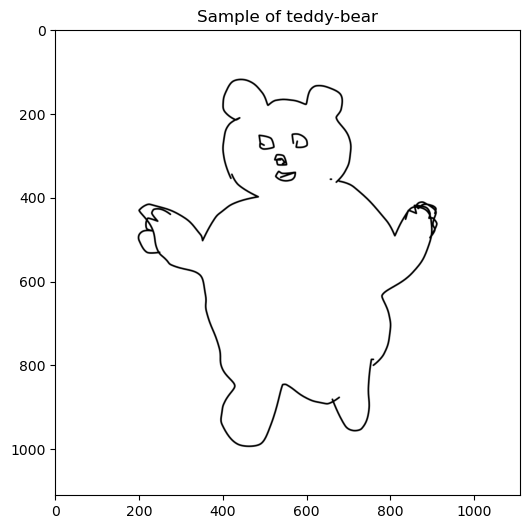

In [141]:
sample = data.sample(1)

def showSketch_init(sample):
  plt.figure(figsize=(6,7),dpi=100)
  img = plt.imread(sample['path'].item())
  imgplot = plt.imshow(img, cmap="gray")
  plt.title(f"Sample of {sample['object'].item()}")
  plt.show()

showSketch_init(sample)

In [142]:
img = plt.imread(sample['path'].item())
print(img.shape)
img

(1111, 1111)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

## Model Plan
* The idea is to take in one of the objects as an input and generate a sketch which corresponds to the object. Since we have 250 object classes, our input to the model would be an array of size 250. Each object would be represented by a combination of the input array.

* The output of the model would be the image. In this case, an array of (1111,1111).

### PyTorch Dataset & Transformers

In [143]:
transformFnx = v2.Compose([v2.ToImage(),
                           v2.Resize((512,512)),
                           v2.RandomHorizontalFlip(0.5),
                           v2.ToDtype(torch.float32, scale=True)])

In [301]:
class datasetGen(Dataset):
  def __init__(self,data,transforms=None):
    self.data = data
    self.transforms = transforms

    nunq = data.object.nunique()
    self.inpMap, ptr = {}, 0
    for obj in sorted(data.object.unique()):
      self.inpMap[obj] = [0]*nunq
      self.inpMap[obj][ptr] = 1
      ptr+=1

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    obj = self.inpMap[row['object']]
    sketch = read_image(row['path'])

    if self.transforms:
      sketch = self.transforms(sketch)

    return sketch, torch.tensor(obj)
        
    # return {'object': obj, 'sketch': sketch}
      
gen = datasetGen(data=data, transforms=transformFnx)
iterGen = iter(gen)

In [302]:
sample

,fileName,object,path
17565,17566.png,teddy-bear,C:\Users\asuto\Desktop\Work\sketches_png\png/t...


In [303]:
# next(iterGen).values()
# next(iterGen)

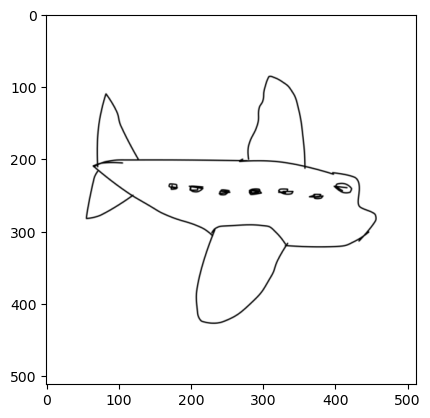

In [304]:
# obj, op = next(iterGen).values()
op,obj = next(iterGen)
plt.imshow(op.reshape(op.shape[::-1]),cmap='gray')
plt.show()

In [305]:
obj

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [306]:
%%time
print("Initial Data Length:",data.shape[0])
trainvalData, testData = train_test_split(data,test_size=0.2,stratify=data['object'])
print(f"TrainVal Split: {trainvalData.shape[0]} ({(trainvalData.shape[0]/data.shape[0])*100:.2g}%), Test Split: {testData.shape[0]} ({(testData.shape[0]/data.shape[0])*100:.2g}%)")

trainData, valData = train_test_split(trainvalData,test_size=0.3,stratify=trainvalData['object'])
print(f"Train Split: {trainData.shape[0]} ({(trainData.shape[0]/data.shape[0])*100:.2g}%), Val Split: {valData.shape[0]} ({(valData.shape[0]/data.shape[0])*100:.2g}%)")

Initial Data Length: 20000
TrainVal Split: 16000 (80%), Test Split: 4000 (20%)
Train Split: 11200 (56%), Val Split: 4800 (24%)
CPU times: total: 31.2 ms
Wall time: 48.3 ms


In [307]:
%%time
trainDataGen = datasetGen(data=trainData, transforms=transformFnx)
valDataGen = datasetGen(data=valData, transforms=transformFnx)
testDataGen = datasetGen(data=testData, transforms=transformFnx)

CPU times: total: 0 ns
Wall time: 7.75 ms


In [308]:
%%time
batch_size = 8

dataLoad_train = DataLoader(trainDataGen,batch_size=batch_size,shuffle=True)
dataLoad_val = DataLoader(valDataGen,batch_size=batch_size,shuffle=True)
dataLoad_test = DataLoader(testDataGen,batch_size=batch_size,shuffle=True)

CPU times: total: 0 ns
Wall time: 6 ms


### Model Creation

In [309]:
# [(W−K+2P)/S]+1
calcDims = lambda w,k,p=0,s=1 : ((w-k+2*p)/s)+1 

calcDims(512, 3, 2, 1)
calcDims(485, 3, 2, 1)

487.0

In [334]:
class sketchModel(nn.Module):
    def __init__(self, latentDims, numClasses):
        super(sketchModel, self).__init__()

        self.latentDims = latentDims
        self.numClasses = numClasses

        self.fc_mu = nn.Linear(1020, latentDims)
        self.fc_logvar = nn.Linear(1020, latentDims)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 12, kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(12*64*64, 1020)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latentDims+numClasses, 128),
            # nn.Linear(latentDims, 128),
            nn.ReLU(),
            nn.Linear(128, 64*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )

    def reparametrize(self, mu ,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z
        
    def forward(self,*inp):
        x, y = inp
        xe = self.encoder(x)
        mu = self.fc_mu(xe)
        logvar = self.fc_logvar(xe)
        z = self.reparametrize(mu, logvar)
        xd = torch.cat([z,y], dim=1)
        xd = self.decoder(xd)
    
        return xd

model = sketchModel(latentDims = 4, numClasses = 250)

In [336]:
_,op = next(enumerate(dataLoad_train))

print(summary(model,input_data=op))

Layer (type:depth-idx)                   Output Shape              Param #
sketchModel                              [8, 1, 32, 32]            --
├─Sequential: 1-1                        [8, 1020]                 --
│    └─Conv2d: 2-1                       [8, 32, 256, 256]         320
│    └─ReLU: 2-2                         [8, 32, 256, 256]         --
│    └─Conv2d: 2-3                       [8, 64, 128, 128]         18,496
│    └─ReLU: 2-4                         [8, 64, 128, 128]         --
│    └─Conv2d: 2-5                       [8, 12, 64, 64]           6,924
│    └─Flatten: 2-6                      [8, 49152]                --
│    └─Linear: 2-7                       [8, 1020]                 50,136,060
├─Linear: 1-2                            [8, 4]                    4,084
├─Linear: 1-3                            [8, 4]                    4,084
├─Sequential: 1-4                        [8, 1, 32, 32]            --
│    └─Linear: 2-8                       [8, 128]              

In [337]:
64*8*8

4096

---

In [ ]:
class Encoder(nn.Module):
    def __init__(self, img_channels, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.num_classes = num_classes
        self.img_channels = img_channels
        self.latent_dim = latent_dim
        
        # Class label embedding layer
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(img_channels + num_classes, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        
        # Latent variables (mean and log-variance)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x, c):
        # Embedding the class label
        c = self.label_embedding(c)
        c = c.view(c.size(0), c.size(1), 1, 1)  # Reshape to (batch, channels, 1, 1)
        c = c.expand(-1, -1, x.size(2), x.size(3))  # Match the spatial dimensions of the image
        
        # Concatenate image and class label
        x = torch.cat([x, c], dim=1)
        
        # Pass through the convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        
        x = torch.relu(self.fc1(x))
        
        # Output the mean and log-variance for the latent distribution
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar


In [ ]:
class Decoder(nn.Module):
    def __init__(self, img_channels, latent_dim, num_classes):
        super(Decoder, self).__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.img_channels = img_channels
        
        # Class label embedding
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # Fully connected layers
        self.fc1 = nn.Linear(latent_dim + num_classes, 128)
        self.fc2 = nn.Linear(128, 64 * 8 * 8)
        
        # Convolutional layers for image reconstruction
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(32, img_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z, c):
        # Embedding the class label
        c = self.label_embedding(c)
        
        # Concatenate latent vector and class label
        x = torch.cat([z, c], dim=1)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        x = x.view(x.size(0), 64, 8, 8)  # Reshape for convolution
        
        # Upsample to original image size
        x = torch.relu(self.conv1(x))
        img = torch.sigmoid(self.conv2(x))  # Final image reconstruction
        return img


In [ ]:
class CVAE(nn.Module):
    def __init__(self, img_channels, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.encoder = Encoder(img_channels, latent_dim, num_classes)
        self.decoder = Decoder(img_channels, latent_dim, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def forward(self, x, c):
        # Encode
        mu, logvar = self.encoder(x, c)
        
        # Reparameterize to sample z
        z = self.reparameterize(mu, logvar)
        
        # Decode
        recon_x = self.decoder(z, c)
        
        return recon_x, mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 32*32*3), x.view(-1, 32*32*3), reduction='sum')
    
    # KL divergence loss
    # KL divergence between q(z|x) and p(z), where p(z) is a standard normal
    # D_KL(q(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where q(z|x) is the latent variable distribution (Gaussian)
    # and p(z) is the standard normal distribution N(0, I)
    # In this case we just calculate the element-wise sum
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Final loss
    return BCE + KL_div


In [ ]:
# Hyperparameters
latent_dim = 128
num_classes = 10  # CIFAR-10 has 10 classes
img_channels = 3  # RGB images
batch_size = 64
learning_rate = 1e-3
epochs = 10

# Create the model, optimizer, and loss function
model = CVAE(img_channels, latent_dim, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data loader (for CIFAR-10)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(inputs, labels)
        
        # Compute loss
        loss = vae_loss(recon_batch, inputs, mu, logvar)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(trainloader)}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / len(trainloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), 'cvae_model.pth')


In [ ]:
def generate_image(model, class_label, latent_dim=128):
    model.eval()
    
    # Sample a random latent vector z
    z = torch.randn(1, latent_dim).to(device)
    
    # Generate an image conditioned on the class label
    class_label = torch.tensor([class_label]).to(device)
    generated_img = model.decoder(z, class_label)
    
    return generated_img.squeeze().cpu().detach().numpy()

# Example: Generate an image for class "cat" (class index 3)
generated_image = generate_image(model, class_label=3)
plt.imshow(generated_image.transpose(1, 2, 0))
plt.show()
